In [1]:
import numpy as np
import torch
from discrete_network.network import KNNet, KNNetParameters, KNNetState
from discrete_network.method.force_method import ForceParameters, ForceLearn
from discrete_network.device import device
import matplotlib.pyplot as plt

print(f"Device = {device.type}")


Device = cuda


In [2]:
params_spiking = KNNetParameters(eps = 0.015, beta = 0.0, d = 0.26, a = 0.25, J = 0.1081 + 0.1)

def one_neuron(x0, y0, iteration, p: KNNetParameters):
    """The dynamics of one neuron. Return x, y."""
    x, y = np.zeros(iteration), np.zeros(iteration)
    x[0], y[0] = x0, y0
    for i in range(iteration - 1):
        x[i + 1] = (
            x[i]
            + x[i] * (x[i] - p.a) * (1 - x[i])
            - p.beta * (x[i] > p.d)
            - y[i]
        )
        y[i + 1] = y[i] + p.eps * (x[i] - p.J)
    return x, y


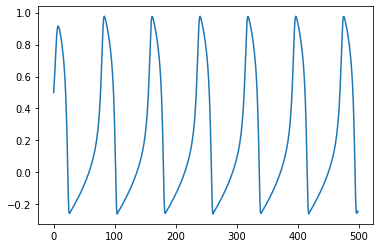

In [3]:
imin = 0; icrit =20000; nt = 21000
f_out, _ = one_neuron(.5, 0, nt, params_spiking)
%matplotlib inline
plt.figure()
plt.plot(f_out[0:500])
plt.show()
plt.close()

In [4]:
f_out = f_out.reshape(f_out.shape[0], 1)
print(f_out.shape)

(21000, 1)


In [5]:
input_size = 0
hidden_size = 3000
output_size = 1
eps_m = 0.019
delta_eps = 0.004
a = 0.25
eps = -delta_eps + 2 * delta_eps * torch.rand(hidden_size, 1).to(device) + eps_m
#eps = torch.as_tensor(eps_m).to(device)
J = (1 + a - torch.sqrt(1 + a * a - a + 3 * eps)) / 3 + 0.01 # Slightly more bifurcation value
J = J.to(device)
p = KNNetParameters(eps=eps, J=J, q=0.5)


x_initial = 0.6 * torch.rand(hidden_size, 1).to(device)
y_initial = torch.zeros(hidden_size, 1).to(device)
z_initial = torch.zeros(hidden_size, 1).to(device)
ISPC_initial = torch.zeros(hidden_size, 1).to(device)
initial_state = KNNetState(x=x_initial, y=y_initial, z=z_initial, ISPC=ISPC_initial)
net = KNNet(input_size, hidden_size, output_size, p=p)
net.to_device(device)
lp = ForceParameters(stop_learning=icrit, start_learning=imin)
fl = ForceLearn(net=net, lp=lp, save_states=True)


In [6]:
f_out = f_out.reshape((f_out.shape[0], 1))
print(f"f_out.shape = {f_out.shape}")


f_out.shape = (21000, 1)


In [7]:
train_logs, states = fl.train(target_outputs=f_out, state=initial_state)


100%|██████████| 21000/21000 [00:49<00:00, 424.14it/s]


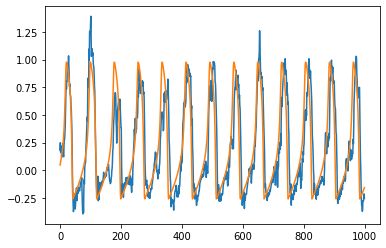

In [8]:
plt.plot(train_logs.numpy()[-1000:, 0, 0])


plt.plot(f_out[-1000:, 0])
plt.show()
plt.close()


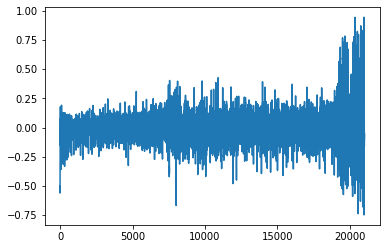

In [9]:
plt.plot((train_logs.numpy()[:, 0, 0] - f_out[:, 0]))


In [10]:

x = []
y = []
for i in range(len(states)):
    x.append(states[i].x)
    y.append(states[i].y)
x = torch.stack(x)
y = torch.stack(y)

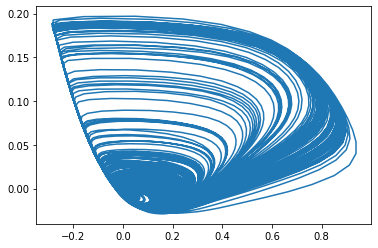

In [11]:
plt.plot(x.numpy()[:, 5], y.numpy()[:, 5])

In [12]:
from discrete_network.pca.pca import PCA
x = x.reshape(*x.shape[0:2])

pca = PCA(3)
pca_x = pca.decompose(x[-1000:])

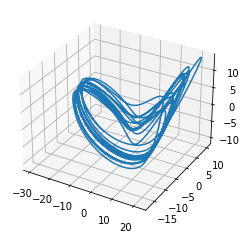

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1], pca_x.numpy()[:, 2])